# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [90]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
import nltk
#nltk.download('punkt')
#nltk.download()
import nltk
#!pip install spacy
#!pip3 install torch torchvision torchaudio
import spacy.cli
#spacy.cli.download("en_core_web_sm")
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import torch
#!pip install transformers
import transformers
import re
import time

from tqdm.auto import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()
print("Setup Complete")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Setup Complete


## Load Data

In [91]:
df_reviews = pd.read_csv('/content/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [92]:
df_reviews.shape

(47331, 17)

In [93]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [94]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [95]:
df_reviews['pos'].value_counts(normalize=True)*100

0    50.104583
1    49.895417
Name: pos, dtype: float64

In [96]:
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [97]:
df_reviews.duplicated().sum()

0

In [98]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [99]:
df_reviews['start_year'].value_counts()

2006    3275
2005    3076
2003    2355
2004    2228
2000    2108
        ... 
1908       2
1910       1
1902       1
1964       1
1912       1
Name: start_year, Length: 107, dtype: int64

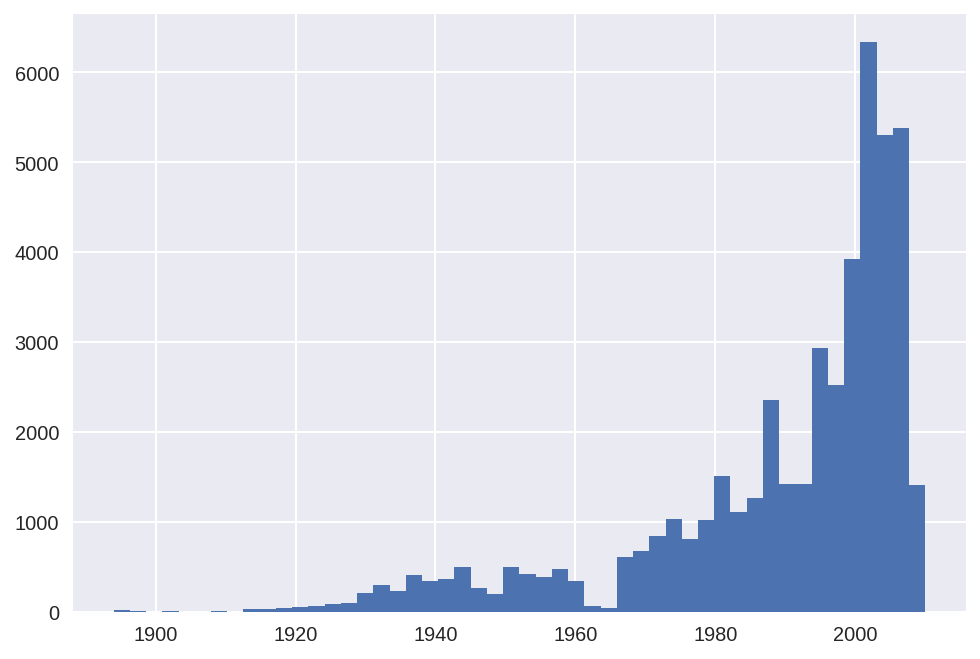

In [100]:
df_reviews['start_year'].hist(bins=50);

## EDA

### Number of movies and reviews over years

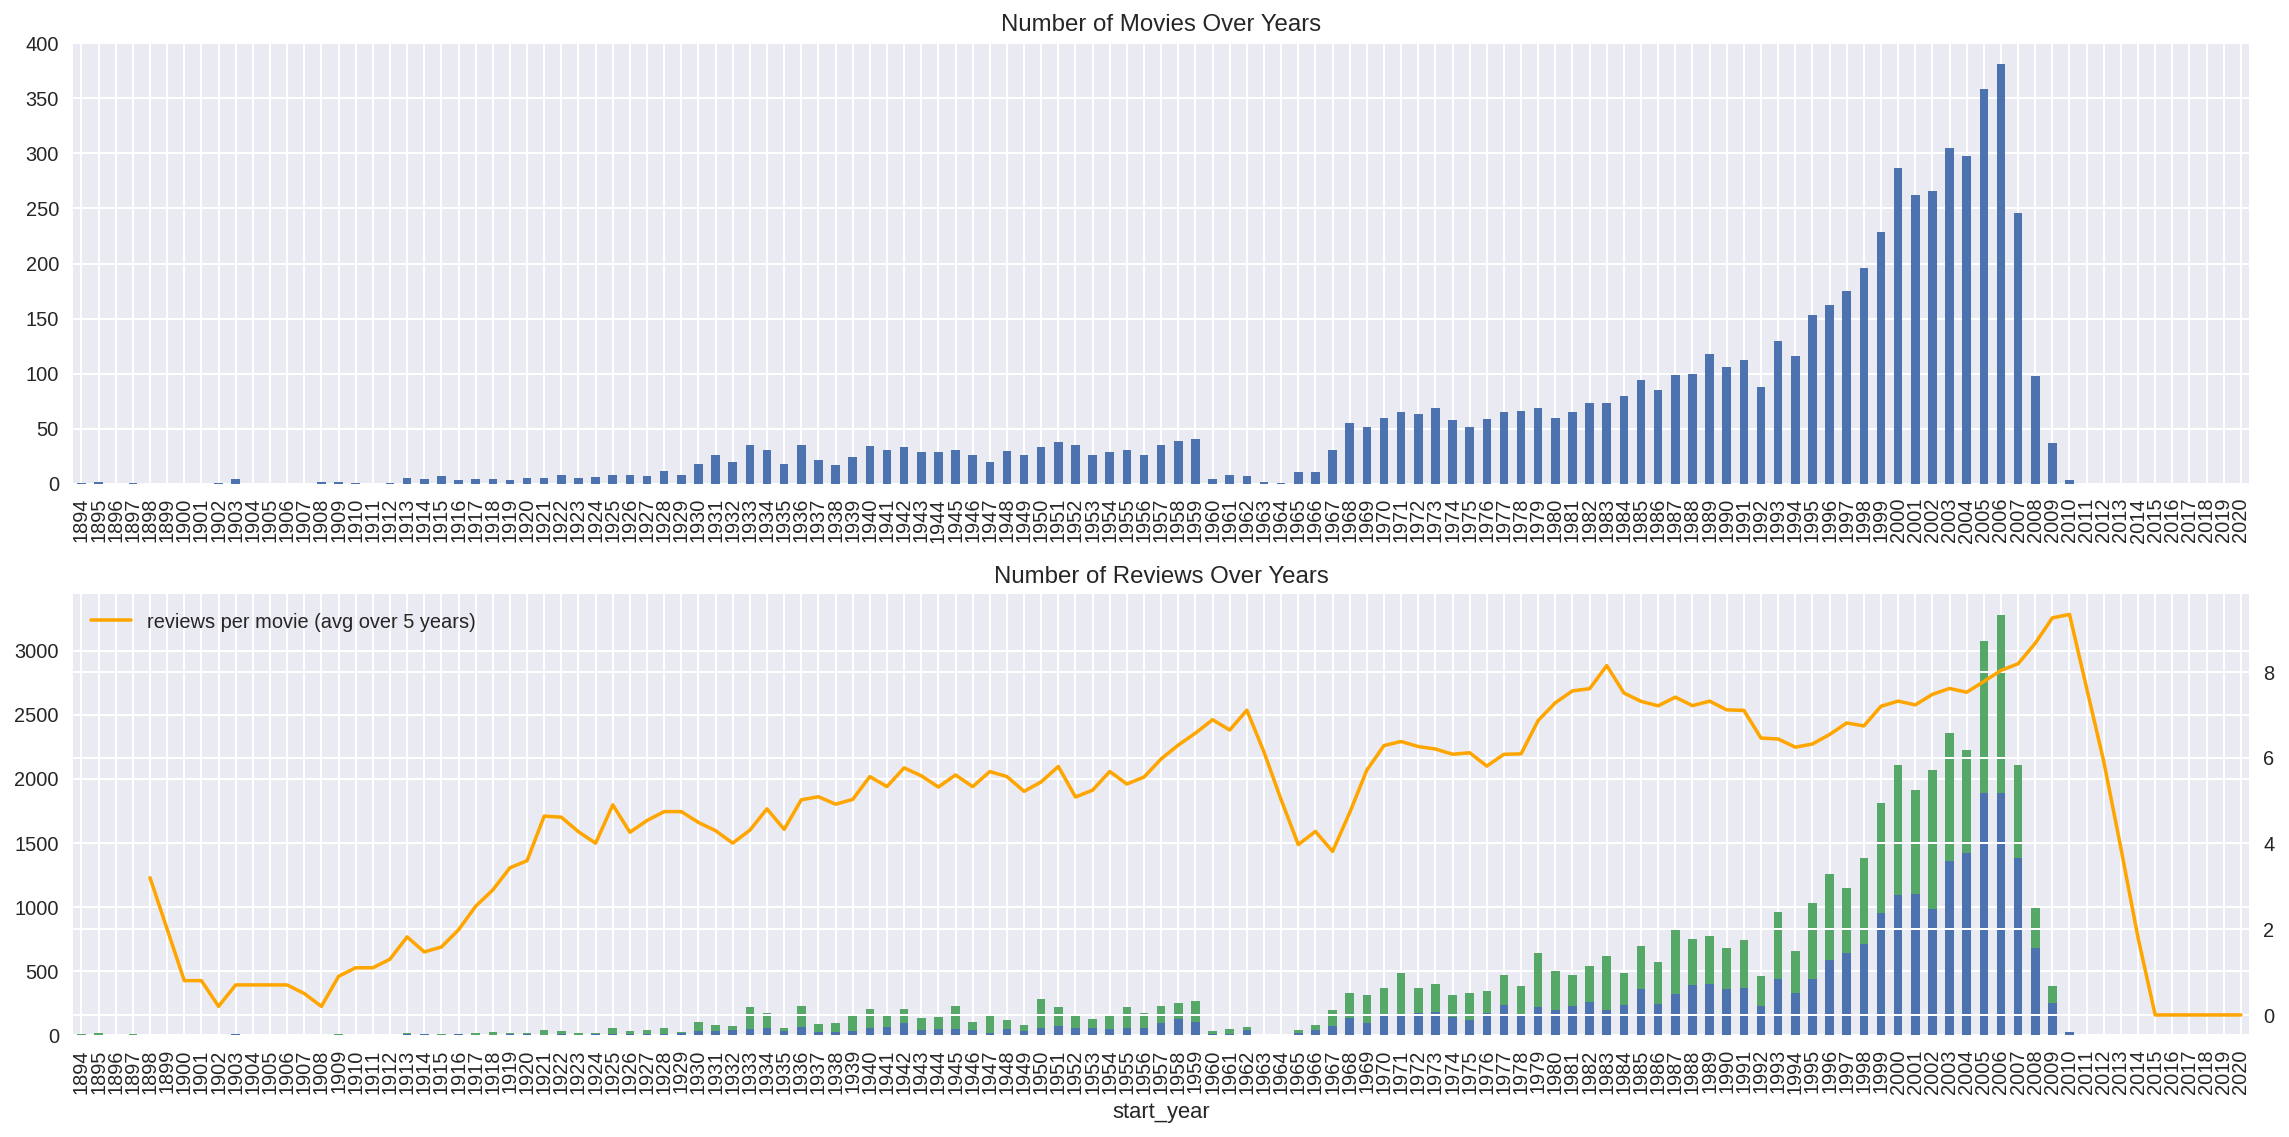

In [101]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

### Distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

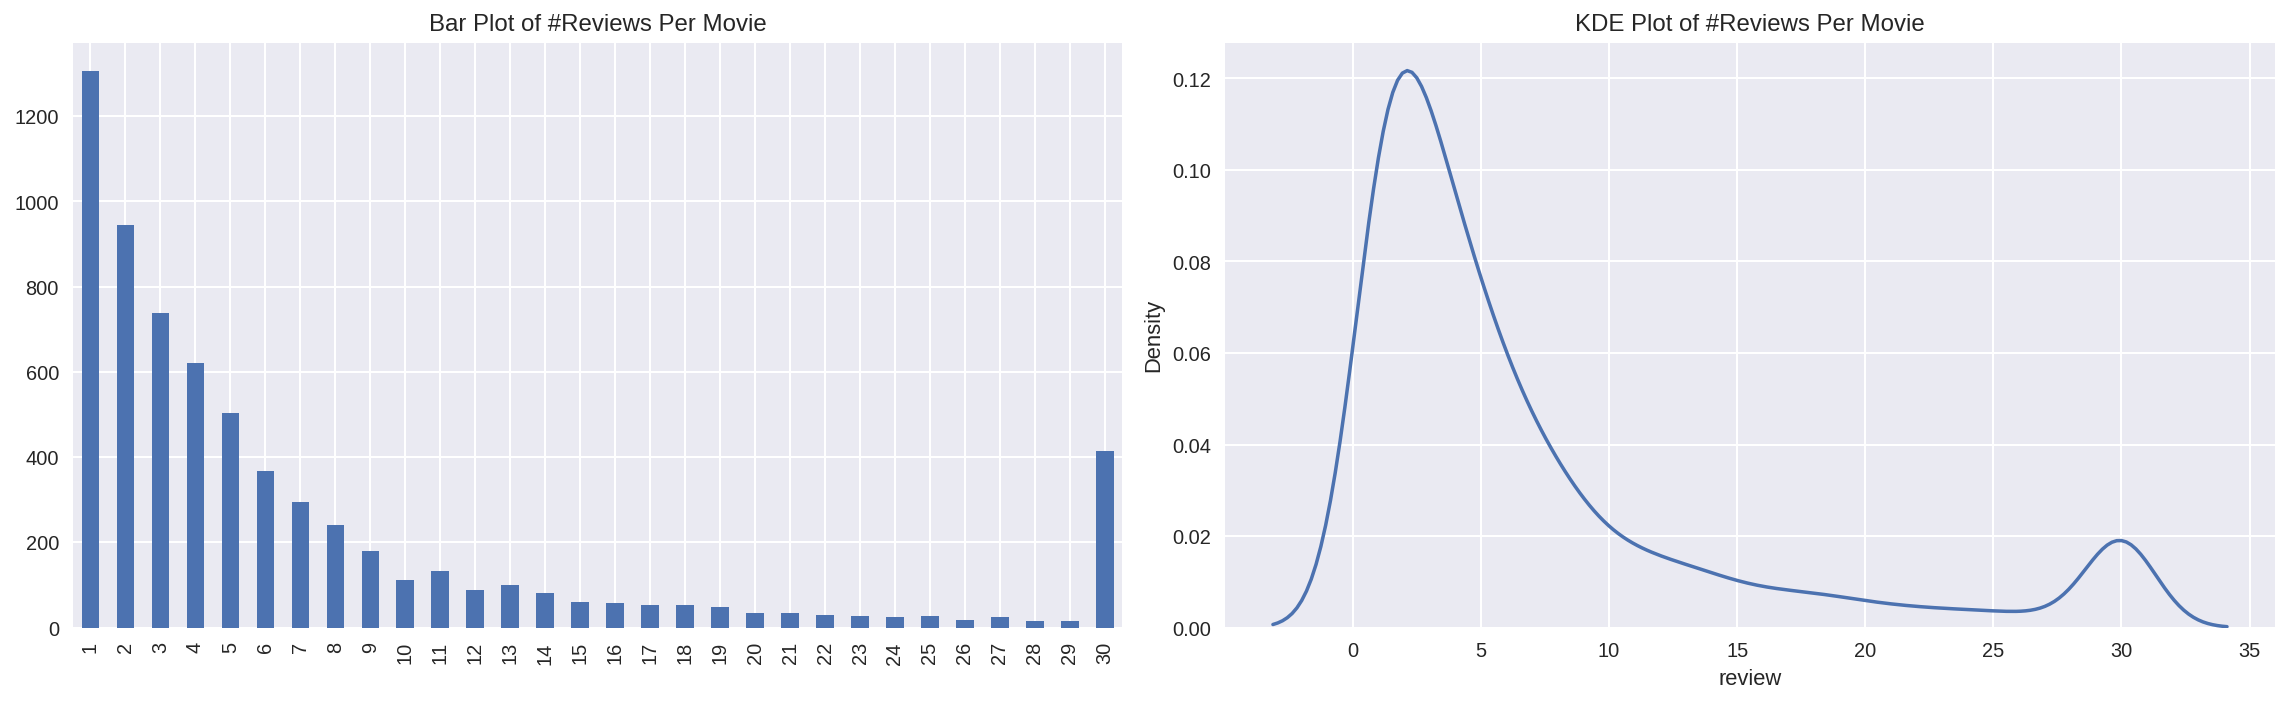

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [103]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

### Distribution of negative and positive ratings in the train and test sets

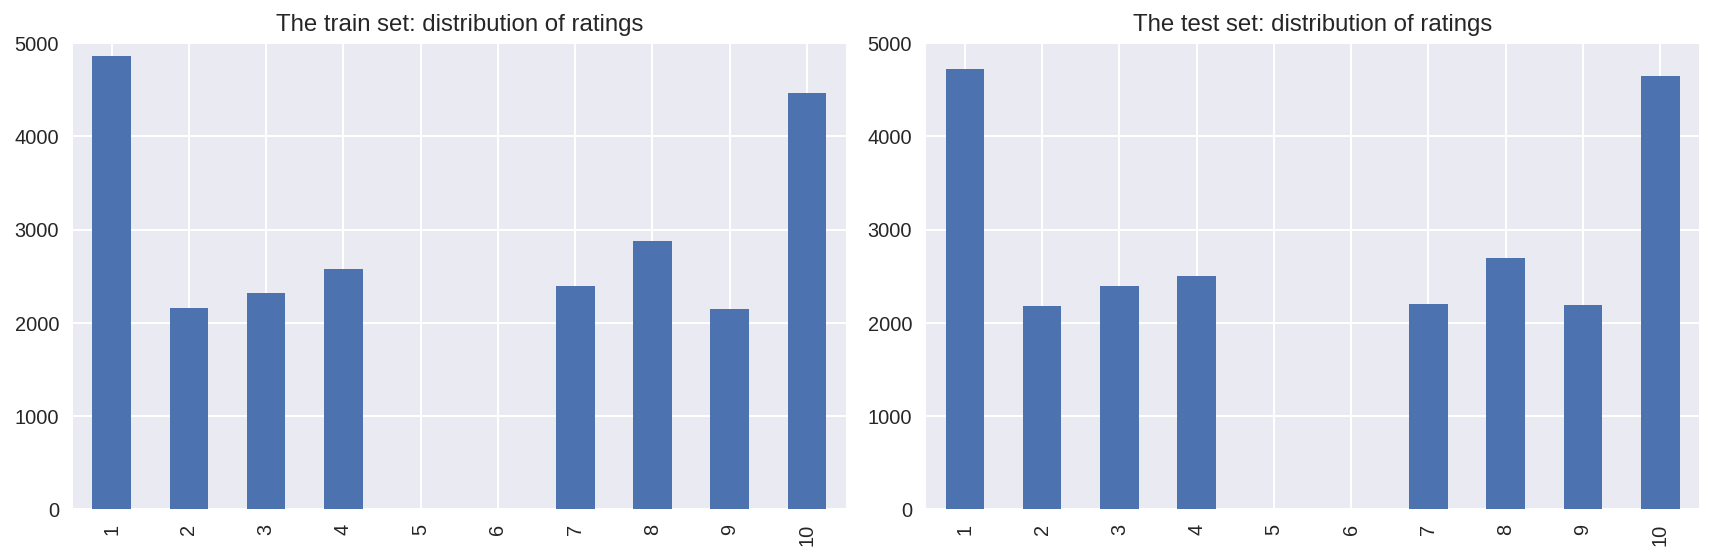

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

### Distribution of negative and positive reviews over the years for two parts of the dataset

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


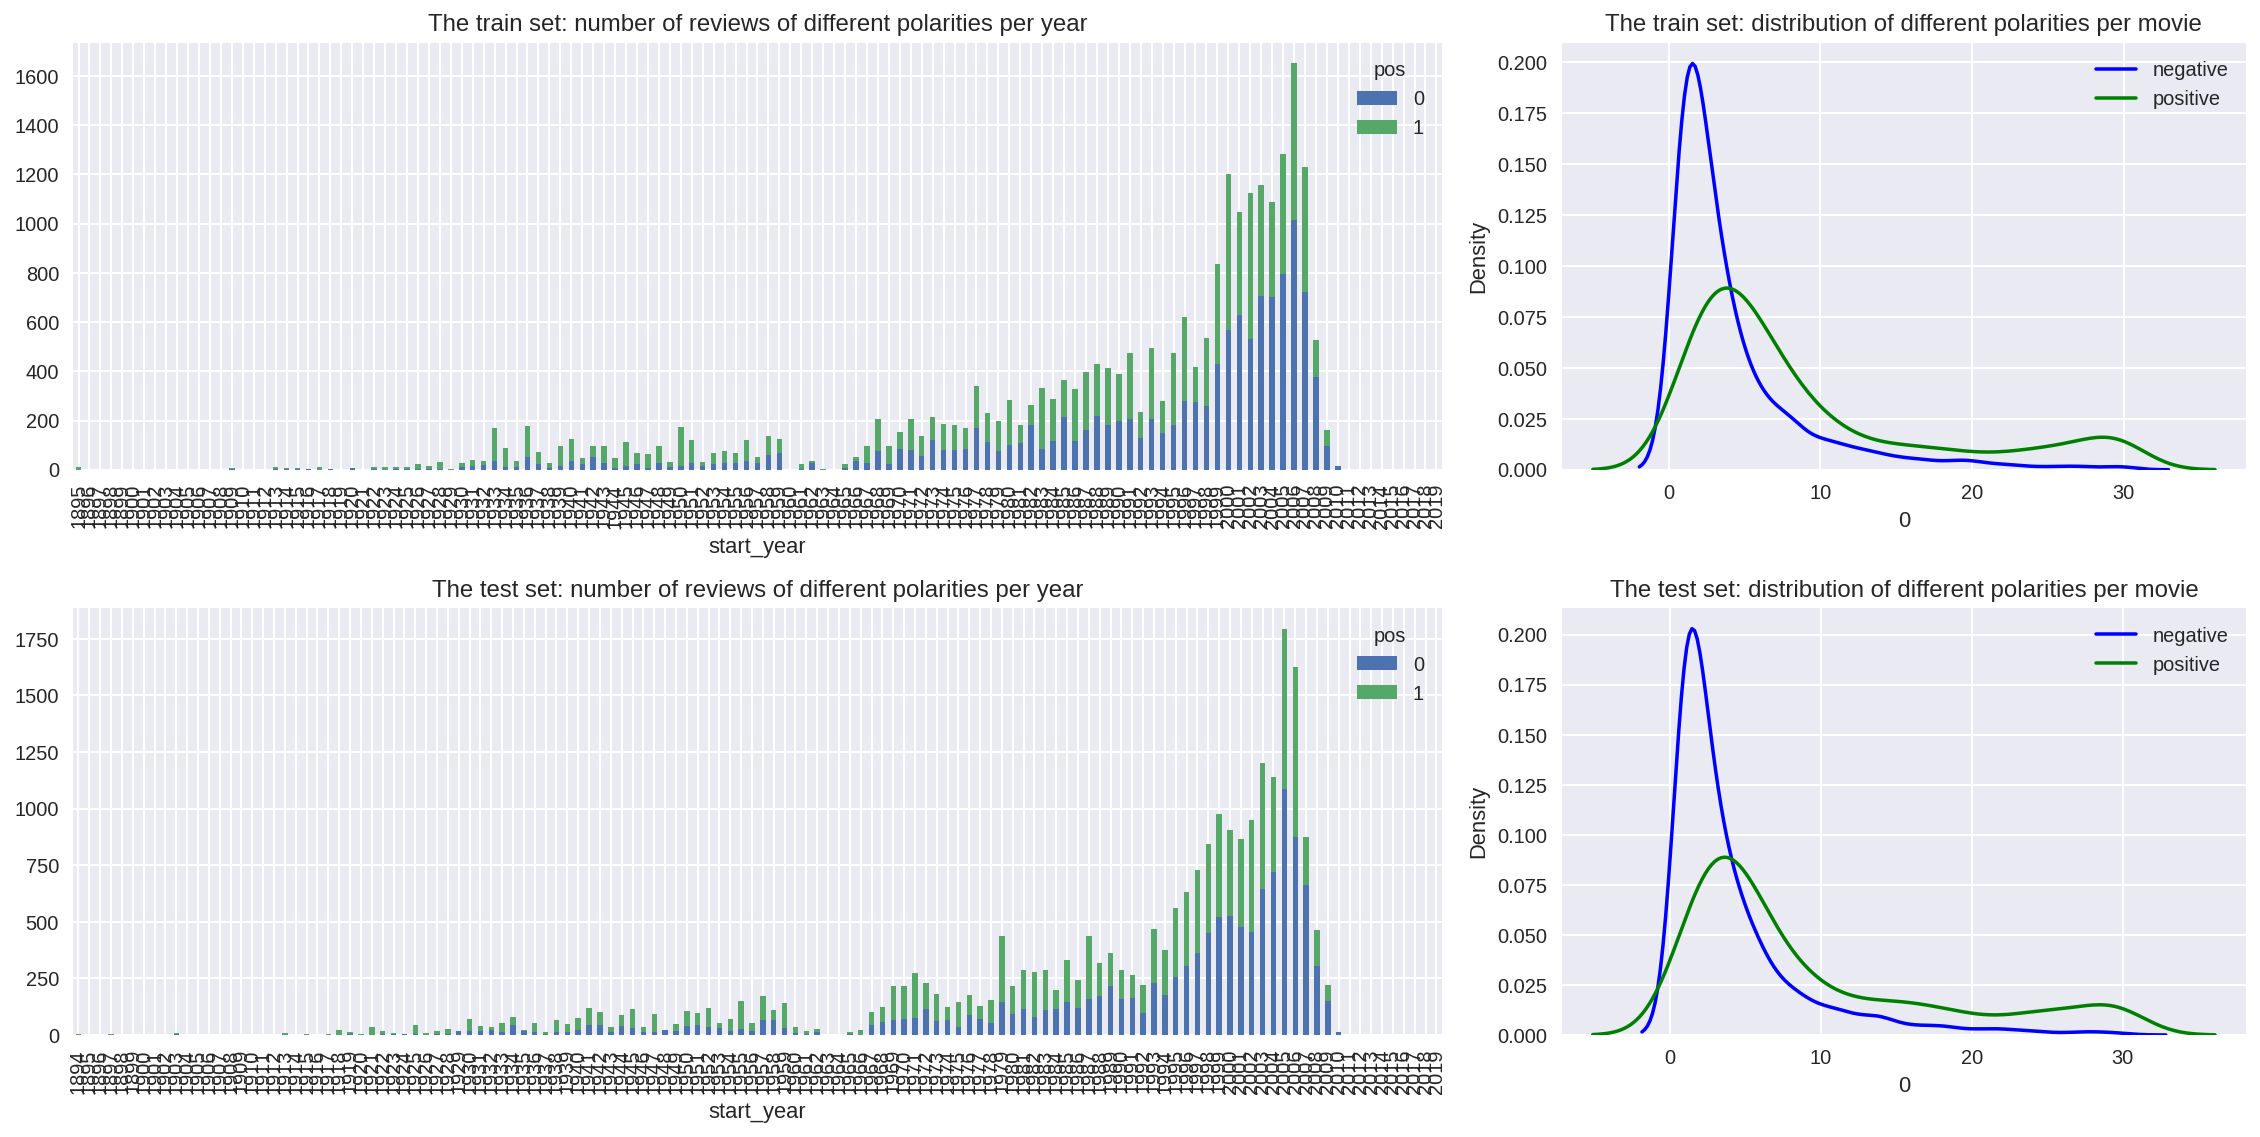

In [105]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

### Conclusion

## Modelling preparation

### Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [106]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

### Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [107]:
lemmatizer  = WordNetLemmatizer()

In [108]:
def clean_reviews(text):
    """
    Clean the review
    https://stackoverflow.com/questions/51784964/remove-emojis-from-multilingual-unicode-text/51785357#51785357
    """
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\']', ' ', text)
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = re.sub(r'\s+', ' ', text)
    return text

In [109]:
df_reviews['reviews_norm'] = df_reviews['review'].apply(clean_reviews)

### Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [110]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_y = df_reviews_train['pos']
test_y = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


### Build Model Function

In [111]:
def build_model(model, train_X, train_y, test_X, test_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], 
                early_stopping_rounds=50, verbose=False):
    """
    Build model
    """
    np.random.seed(42)
    best_score = 0
    start_time = time.time()
    
    if model_str == 'dummy':
        model.fit(train_X, train_y)
        preds = model.predict(train_X)
        best_score = f1_score(train_y, preds)
        return model, best_score, np.round(time.time() - start_time, 2)
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'lgbm':
        gs.best_estimator_.fit(train_X, train_y, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(test_X)
    best_score = f1_score(test_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_score, np.round(end_time, 2)

## Modeling

### Model 1 - Constant

In [112]:
dc = DummyClassifier()
best_dc_model, best_dc_f1, best_dc_time = build_model(dc, df_reviews_train['reviews_norm'], train_y, 
                                                        df_reviews_test['reviews_norm'], test_y,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=2, model_str='dummy')

In [113]:
best_dc_f1

0.0

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


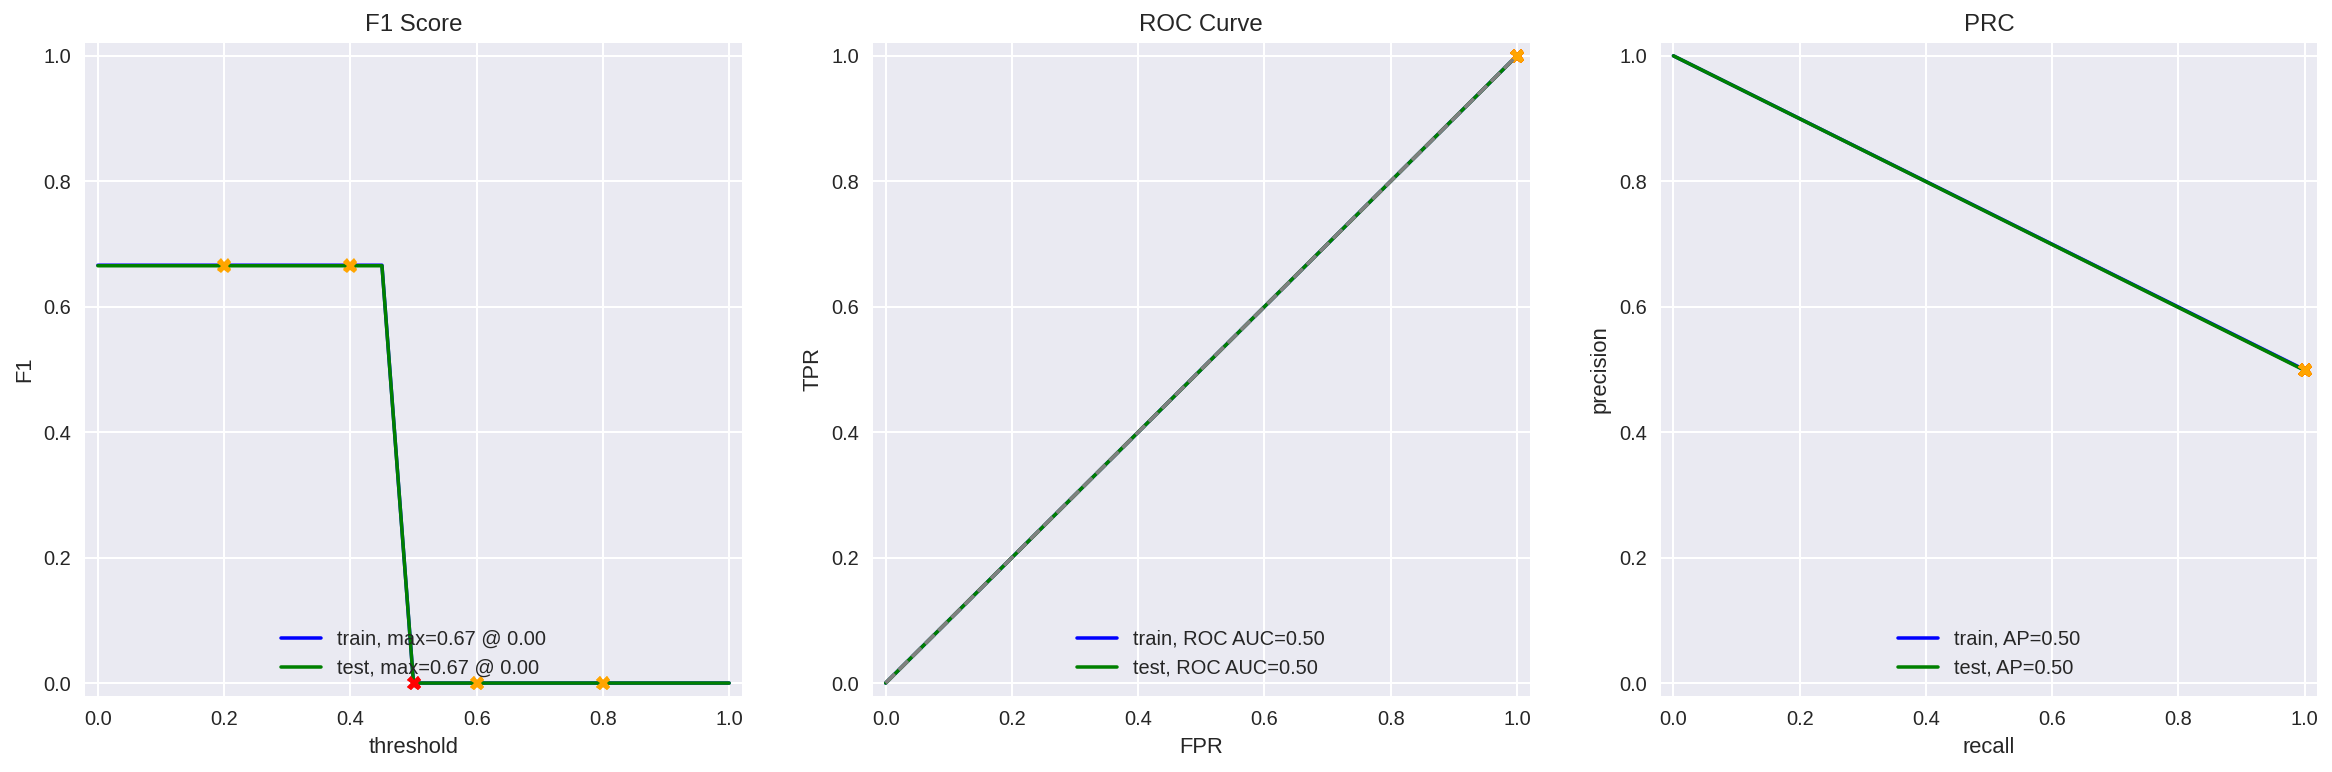

In [114]:
evaluate_model(best_dc_model, df_reviews_train['reviews_norm'], train_y, df_reviews_test['reviews_norm'], test_y)

### Model 2 - NLTK, TF-IDF and LR

#### Text preprocessing

In [116]:
def text_preprocessing_1(text):
    """
    Word tokenize and lemmatize text
    """
    tokens = word_tokenize(text)
    return " ".join(lemmatizer.lemmatize(token) for token in tokens)

In [117]:
%%time
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
df_reviews_train['reviews_nltk'] = df_reviews_train['reviews_norm'].apply(text_preprocessing_1)
df_reviews_test['reviews_nltk'] = df_reviews_test['reviews_norm'].apply(text_preprocessing_1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


CPU times: user 1min 6s, sys: 222 ms, total: 1min 6s
Wall time: 1min 8s


In [118]:
%%time
nltk.download('stopwords')
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.9, min_df=10)
train_X = tfidf_vectorizer_1.fit_transform(df_reviews_train['reviews_nltk'])
test_X = tfidf_vectorizer_1.transform(df_reviews_test['reviews_nltk'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: user 5.41 s, sys: 37.1 ms, total: 5.45 s
Wall time: 6.11 s


#### Model

In [119]:
lr = LogisticRegression()
best_lr_model, best_lr_f1, best_lr_time = build_model(lr, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [120]:
# test set - using nltk
best_lr_f1

0.8805154903132201

#### Model eval

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


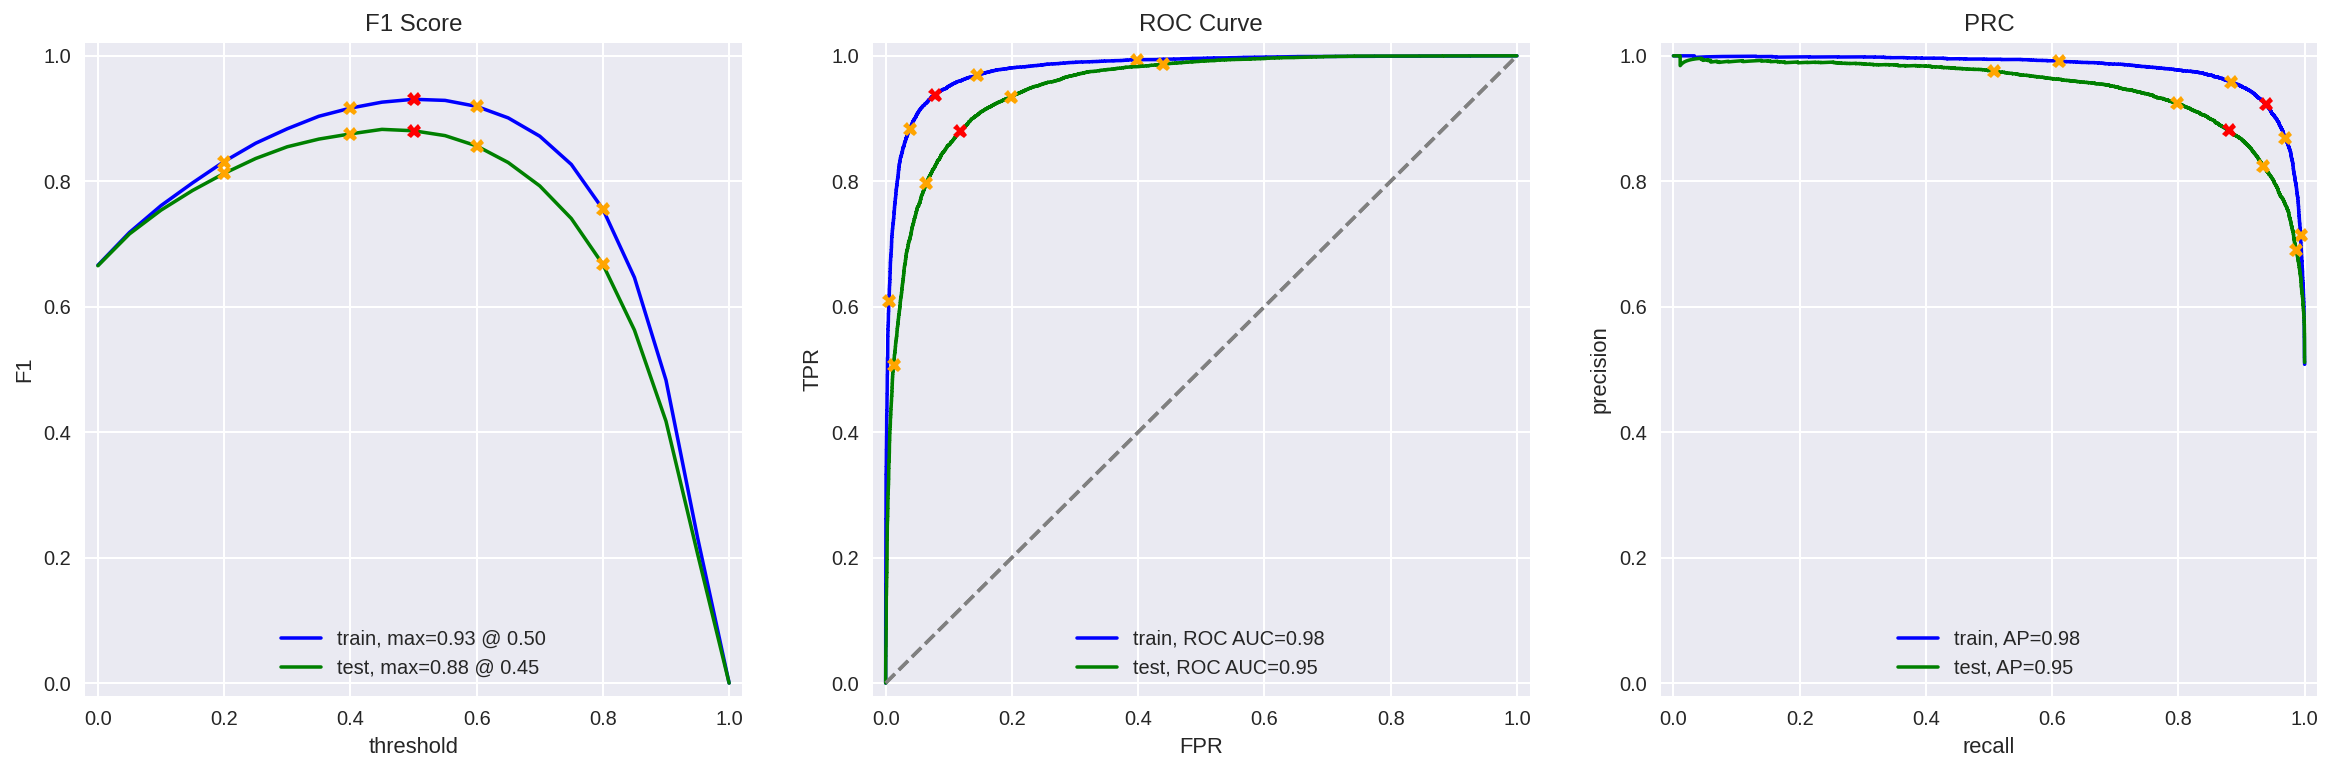

In [121]:
evaluate_model(best_lr_model, train_X, train_y, test_X, test_y)

### Model 3 - spaCy, TF-IDF and LR

#### Text preprocessing

In [122]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [123]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [124]:
%%time
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.9, min_df=10)
df_reviews_train['reviews_spacy'] = df_reviews_train['reviews_norm'].apply(text_preprocessing_3)
df_reviews_test['reviews_spacy'] = df_reviews_test['reviews_norm'].apply(text_preprocessing_3)

CPU times: user 10min 40s, sys: 4.59 s, total: 10min 44s
Wall time: 10min 42s


In [125]:
train_X = tfidf_vectorizer_3.fit_transform(df_reviews_train['reviews_spacy'])
test_X = tfidf_vectorizer_3.transform(df_reviews_test['reviews_spacy'])

#### Model

In [126]:
lr = LogisticRegression()
best_lr_spacy_model, best_lr_spacy_f1, best_lr_spacy_time = build_model(lr, train_X, train_y, 
                                                        test_X, test_y, 
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [127]:
# test set- using spacy
best_lr_spacy_f1

0.8776672617529543

#### Model eval

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


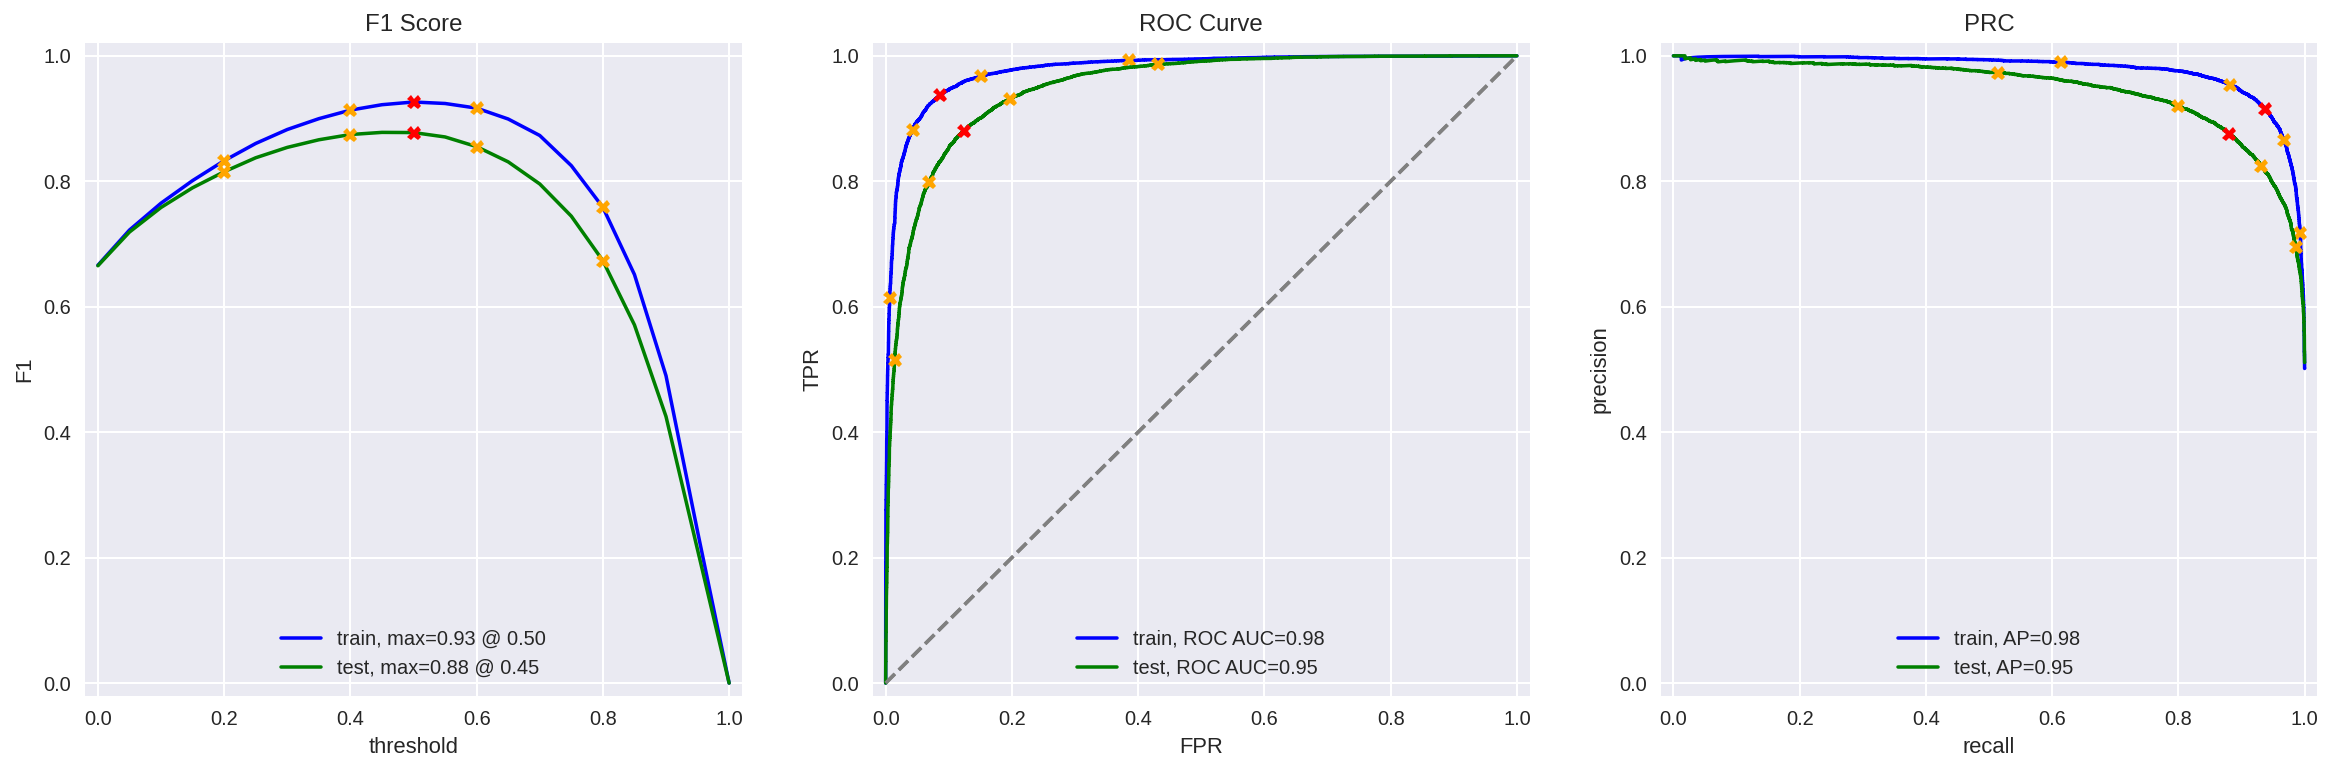

In [128]:
evaluate_model(best_lr_spacy_model, train_X, train_y, test_X, test_y)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [130]:
lgbm = LGBMClassifier(learning_rate=0.1, boosting_type='gbdt',
                      objective='binary',
                      feature_fraction=0.8,
                      random_state=42)
best_lgbm_model, best_lgbm_f1, best_lgbm_time = build_model(lgbm, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'n_estimators': range(100, 600, 100)}, 
                scoring='f1_weighted', cv=3, model_str='lgbm',
           cat_features=[])

In [131]:
# test set- using spacy
best_lgbm_f1

0.8725031874203146

#### Model eval

          train  test
Accuracy   0.99  0.87
F1         0.99  0.87
APS        1.00  0.94
ROC AUC    1.00  0.95


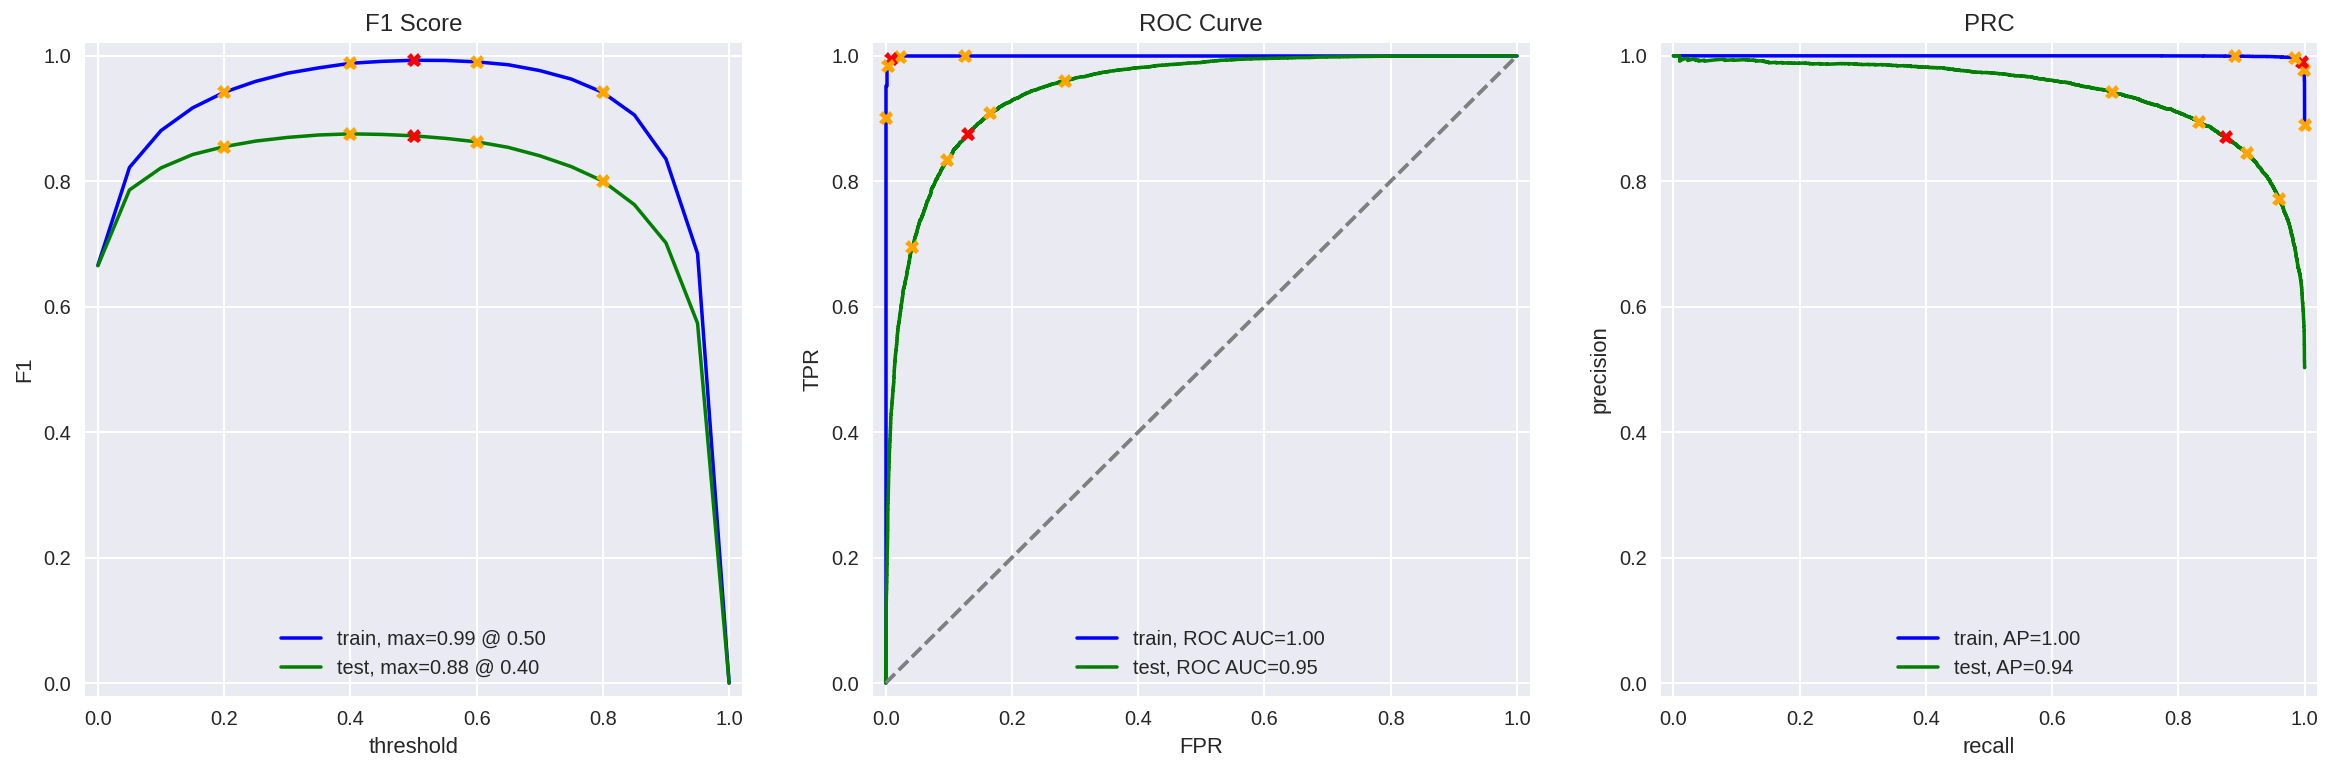

In [132]:
evaluate_model(best_lgbm_model, train_X, train_y, test_X, test_y)

###  Model 5 - BERT

#### Text preprocesing

In [133]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [134]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
    ids_list = texts.apply(lambda x: tokenizer.encode(x.lower(), add_special_tokens=True, truncation=True, max_length=max_length))
    
    ids_list = ids_list.apply(lambda x: np.array(x[:max_length] + [0]*(max_length - len(x))))
    attention_mask_list = ids_list.apply(lambda x: np.where(x != 0, 1, 0))
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)].reset_index(drop=True)).to(device)
        # <put your code here to create attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)].reset_index(drop=True)).to(device)
    
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [135]:
df_reviews_train['reviews_norm'].shape

(23796,)

In [136]:
train_features_5 = BERT_text_to_embeddings(df_reviews_train['reviews_norm'], batch_size=10)

Using the cuda device.


  0%|          | 0/2380 [00:00<?, ?it/s]

In [137]:
test_features_5 = BERT_text_to_embeddings(df_reviews_test['reviews_norm'], batch_size=10)

Using the cuda device.


  0%|          | 0/2354 [00:00<?, ?it/s]

#### Model

In [138]:
lr = LogisticRegression()
best_bert_model, best_bert_f1, best_bert_time = build_model(lr, train_features_5, train_y, 
                                                        test_features_5, test_y,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [139]:
# test set- using bert
best_bert_f1

0.8635953026196929

#### Model eval

          train  test
Accuracy   0.87  0.87
F1         0.87  0.86
APS        0.94  0.94
ROC AUC    0.94  0.94


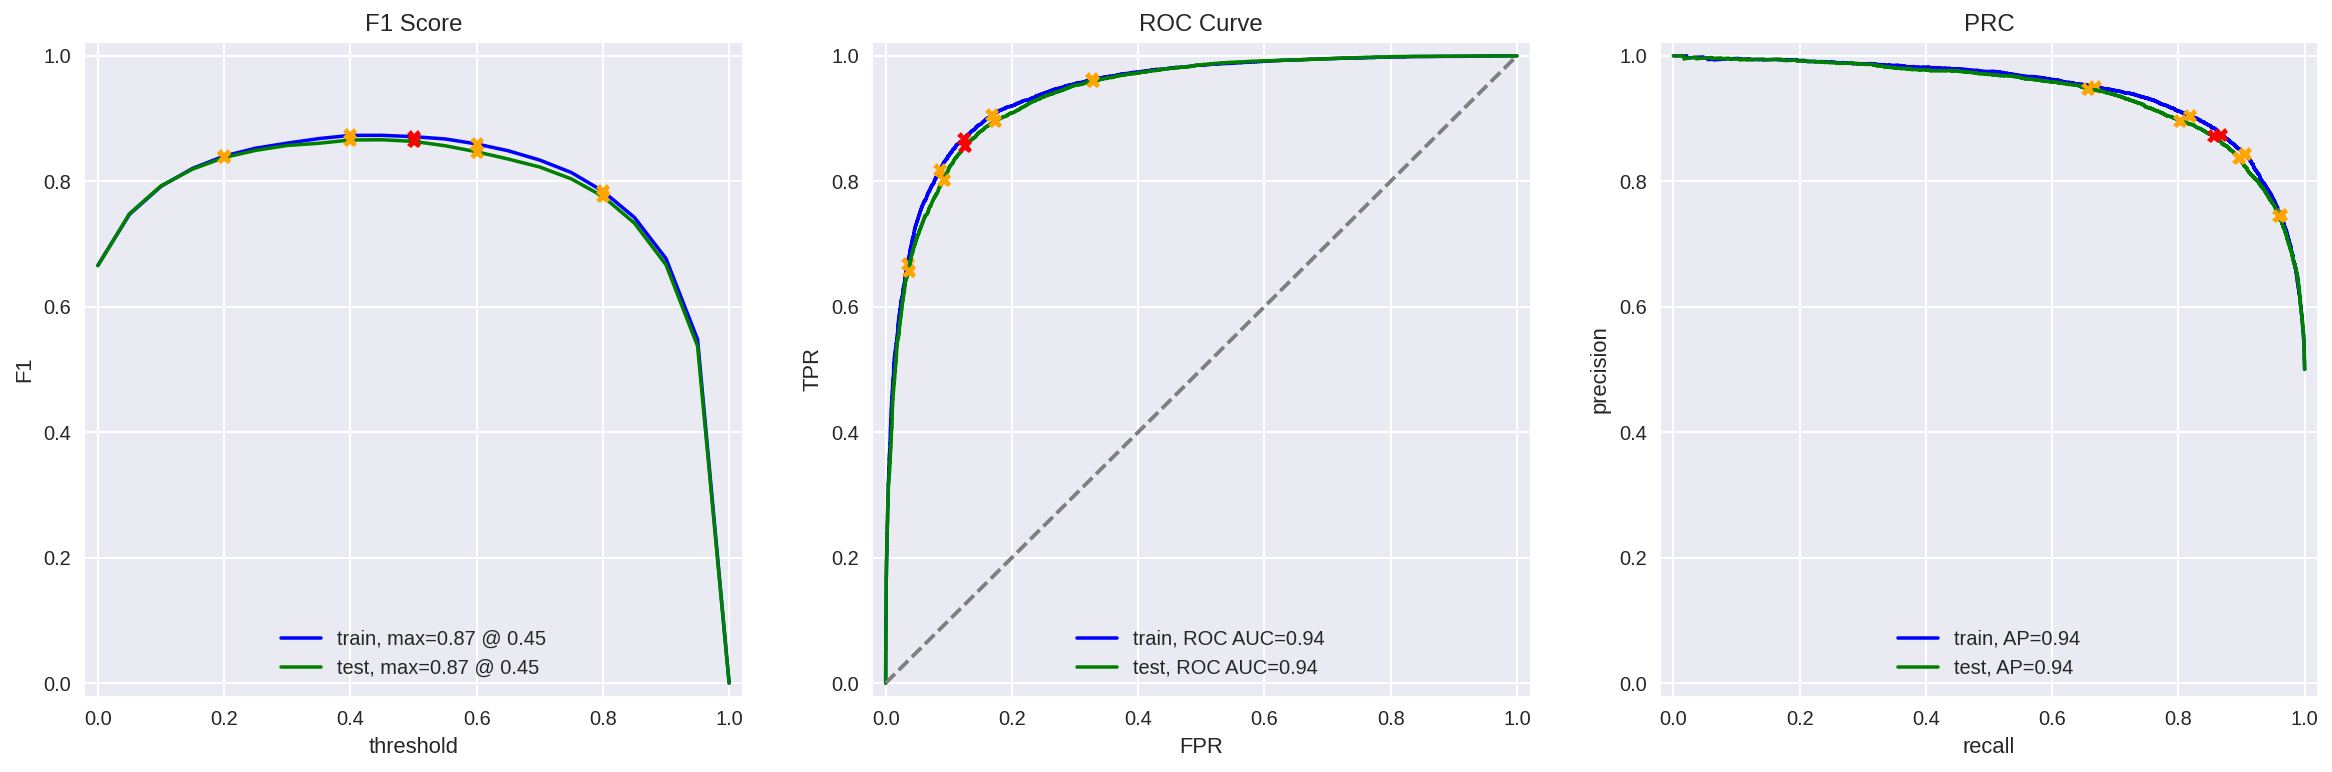

In [140]:
evaluate_model(best_bert_model, train_features_5, train_y, test_features_5, test_y)

## Model Comparison

In [141]:
model_results_df = pd.DataFrame({'model': ['LogisticRegression-NLTK', 'LogisticRegression-Spacy', 'LGBMClassifier', 
                                          'LogisticRegression-BERT'],
              'best_f1': [best_lr_f1, best_lr_spacy_f1, best_lgbm_f1, best_bert_f1],
              'train_time': [best_lr_time, best_lr_spacy_time, best_lgbm_time, best_bert_time]})



In [142]:
model_results_df

,model,best_f1,train_time
0,LogisticRegression-NLTK,0.880515,11.45
1,LogisticRegression-Spacy,0.877667,11.09
2,LGBMClassifier,0.872503,1390.86
3,LogisticRegression-BERT,0.863595,48.06


### Conclusion:
All models have similar performances, but the Gradient LGBT model is too time expensive.

## Testing the model performance on mock data

We will test the performance of the models on mock data.

In [145]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clean_reviews)
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2: NLTK, TF-IDF

In [148]:
texts = my_reviews['review_norm']

model_2 = best_lr_model

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.17:  i did not simply like it not my kind of movie 
0.18:  well i was bored and felt asleep in the middle of the movie 
0.60:  i was really fascinated with the movie
0.16:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.33:  i didn't expect the reboot to be so good writers really cared about the source material
0.52:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


#### Conclusion:
The negative reviews are not very well classified in this model.  The very positive review was only given 0.6.

### Model 3: spaCy, TF-IDF

In [149]:
texts = my_reviews['review_norm']

model_3 = best_lr_spacy_model

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.22:  i did not simply like it not my kind of movie 
0.14:  well i was bored and felt asleep in the middle of the movie 
0.50:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19:  i didn't expect the reboot to be so good writers really cared about the source material
0.52:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


#### Conclusion:
The negative reviews are not very well classified in this model.  The very positive review was only given 0.5, like the mixed review.

### Model 4: spaCy, TF-IDF, LGBM

In [150]:
texts = my_reviews['review_norm']

model_4 = best_lgbm_model

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.58:  i did not simply like it not my kind of movie 
0.26:  well i was bored and felt asleep in the middle of the movie 
0.59:  i was really fascinated with the movie
0.18:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.34:  i didn't expect the reboot to be so good writers really cared about the source material
0.65:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.10:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.93:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


#### Conclusion:
The negative reviews are not very well classified in this model.  The very positive review was only given 0.6 like the first very negative review.

### Model 5: BERT

In [151]:
texts = my_reviews['review_norm']

model_5 = best_bert_model

my_reviews_features_5 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_5.predict_proba(my_reviews_features_5)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.29:  i did not simply like it not my kind of movie 
0.01:  well i was bored and felt asleep in the middle of the movie 
0.97:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.20:  i didn't expect the reboot to be so good writers really cared about the source material
0.95:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.94:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


#### Conclusion:
I do not like that the mixed review was classified a very positive. However, the positive reviews were well classified.  The negative reviews were well classified too.  So the problem in this model is the mixed reviews.  I would say this is a winner because it is able to tease out the negative from the positive

## Conclusions

The goal of this project was to develop a sentiment classifier for movie reviews.  The F1 score on the test should be at least 0.85.  We have completed the following steps in this project:

1.Descriptive statistics

2.Data preprocessing

Checked for missing values and duplicates. 
Normalized data by removing digits, punctuations marks etc. and converting them to lower case letters.

3.EDA

Analyzed both features and targets. We noticed an overall tendency of the growth of movie reviews over the years, with the peak being in 2006. We found that most often there is just one or a few reviews per movie, although more than 400 movies (probably the most popular ones) have 30 reviews. The overall distributions of ratings among the train and test sets are quite similar, we could probably use this feature in our model.

The distributions of the 2 classes of the train and test sets are very similar - it's a good sign, it means that a model trained on the train set should be predicting correctly on the test set as well. We see that the classes are balanced - there is almost the same amount of positive as well as negative reviews.

4.Splitting the data

Data was split into train and test sets almost equally, according to the preexisting split.

5. Modelling 

Used 2 types of word embeddings - TF-IDF and BERT. 
Used 2 libraries for text preprocessing - nltk and spaCy. 
Used Linear Regression and LightGBM models.

6. Results

The analysis shows that all models had an f1 score above the 85\% threshold; the constant model's performance was dismal. Therefore, it is argued that all maodels are similar.  The training time of the LGBM makes is a bad choice. 

7. Additional testing

Additional testing on new data shows that BERT embeddings definitely outperforms its rival TFIDF vectors because it captures the semantic representation of the underlying dataset on which it was trained. Therefore, despite, the relatively higher, yet acceptable training time, BERT embeddings is superior.